<a href="https://colab.research.google.com/github/VIVEK-JADHAV/TweetSentimentExtraction/blob/master/CaseStudy2_BertQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import re 
import string
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Flatten,Embedding,Lambda,Dropout,LSTM,Conv1D
from tensorflow.keras.models import Model
from tqdm import tqdm


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Creating a folder to store train and test data
import os
os.mkdir('/content/data')
%cd /content/data/
!pwd

/content/data
/content/data


In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 46.1MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 42.7MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 83.3MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
#Loading the train dataset

train=pd.read_csv('/content/data/train.csv')
print('Shape of the train data is ',train.shape)
train.head()

Shape of the train data is  (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


* Train dataset has 27481 datapoints and 4 features.

In [ ]:
#Loading the test dataset

test=pd.read_csv('/content/data/test.csv')
print('Shape of the test data is ',test.shape)
test.head()

Shape of the test data is  (3534, 3)


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


* Test dataset has 3534 datapoints and 3 features.

In [ ]:
#Dropping the row with null value
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### BERT

In [ ]:
#Reference:https://www.kaggle.com/akensert/tweet-bert-base-with-tf2-1-mixed-precision

from transformers import  BertConfig, TFBertForQuestionAnswering
from tokenizers import BertWordPieceTokenizer

# Bert Base Uncased Vocabulary
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt

--2020-09-11 05:27:55--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.14.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.14.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-base-uncased-vocab.txt’

bert-base-uncased-v 100%[===================>] 226.08K  1.10MB/s    in 0.2s    

2020-09-11 05:27:56 (1.10 MB/s) - ‘bert-base-uncased-vocab.txt’ saved [231508/231508]



In [ ]:
#Global variables

MAX_LEN=128
tokenizer=BertWordPieceTokenizer('/content/data/bert-base-uncased-vocab.txt')


In [ ]:
#Finding the id value for sentiment values
print(tokenizer.encode('positive').ids)
print(tokenizer.encode('negative').ids)
print(tokenizer.encode('neutral').ids)

[101, 3893, 102]
[101, 4997, 102]
[101, 8699, 102]


In [ ]:
#Creating a sentiment dictionary to create input data
sentiment_dict={'positive':3893,'negative':4997,'neutral':8699}

In [ ]:
#Converting text and selected_text columns to lower case

train['text']=train['text'].apply(lambda x: str.lower(x))
train['selected_text']=train['selected_text'].apply(lambda x: str.lower(x))

In [ ]:
def createData(text,selected_text,sentiment,tokenizer):
  '''Create the data as required for Bert QA model '''
  id0=None
  id1=None
  start_tokens=np.zeros((MAX_LEN),dtype=np.int32)
  end_tokens=np.zeros((MAX_LEN),dtype=np.int32)

  #Find start and end index of selected_text in tweet
  for i,c in enumerate(text):
    if(c==selected_text[0]):
      id0=i
      id1=i+len(selected_text)
      break
  chars=np.zeros(len(text))
  if(id0!=None and id1!=None):
    chars[id0:id1]=1
  token_encode=tokenizer.encode(text)
  token_ids=token_encode.ids[1:-1]
  token_offsets=token_encode.offsets[1:-1]

  target_idx=[]
  for i,(o1,o2) in enumerate(token_offsets):
    if(sum(chars[o1:o2])>0):
      target_idx.append(i)
  
  target_start=target_idx[0]
  target_end=target_idx[-1]

  

  #Creating the input data to the BERT model
  input_ids=[101]+[sentiment_dict[sentiment]]+[102]+token_ids+[102]
  atten_mask=[1]*4+[1]*len(token_ids)
  input_type_ids=[0,0,0]+[1]*(len(token_ids)+1) 

  offsets=[(0,0)]*3+token_offsets+[(0,0)]

  #Adding 3 to target because of 101,sentiment and 102 tokens
  target_start+=3
  target_end+=3
  start_tokens[target_start]=1
  end_tokens[target_end]=1

  pad_length=MAX_LEN-len(input_ids)

  #Padding the excess tokens with [0]
  if(pad_length>0):
    input_ids=input_ids+([0]*pad_length)
    atten_mask=atten_mask+([0]*pad_length)
    input_type_ids=input_type_ids+([0]*pad_length)
    offsets=offsets+([(0,0)]*pad_length)
    

  return (input_ids,atten_mask,input_type_ids,start_tokens,end_tokens,offsets)




In [ ]:
def createInput(data,tokenizer):
  '''Convert to BERT input for all the data points '''
  input_ids=[]
  input_att_mask=[]
  input_type_ids=[]
  offsets=[]
  start_ids=[]
  end_ids=[]

  for _,i in tqdm(data.iterrows()):    
    ids,att_mask,type_ids,start,end,offset=createData(i['text'],i['selected_text'],i['sentiment'],tokenizer)      
    input_ids.append(ids)
    input_att_mask.append(att_mask)
    input_type_ids.append(type_ids)
    start_ids.append(start)    
    end_ids.append(end)
    offsets.append(offset)
  return (np.asarray(input_ids,dtype=np.int32),np.asarray(input_att_mask,dtype=np.int32),
          np.asarray(input_type_ids,dtype=np.int32),np.asarray(start_ids,dtype=np.int32),
          np.asarray(end_ids,dtype=np.int32),np.asarray(offsets,dtype=np.int32))


In [ ]:
#Perform train,validatio and test split

from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train,train['sentiment'],
                                              test_size=0.2,random_state=42,stratify=train['sentiment'])
X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,
                                               test_size=0.2,random_state=42,stratify=X_train['sentiment'])

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

Y_train=Y_train.reset_index(drop=True)
Y_val=Y_val.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

print('X_train shape',X_train.shape,' Y_train shape ',Y_train.shape)
print('X_val shape',X_val.shape,' Y_val shape ',Y_val.shape)
print('X_test shape',X_test.shape,' Y_test shape ',Y_test.shape)

X_train shape (17587, 4)  Y_train shape  (17587,)
X_val shape (5496, 4)  Y_val shape  (5496,)
X_test shape (4397, 4)  Y_test shape  (4397,)


In [ ]:
#Convert train,validation and test data to Bert QA input

X_tr1,X_tr2,X_tr3,Y_tr1,Y_tr2,offsetTr=createInput(X_train,tokenizer)
X_val1,X_val2,X_val3,Y_val1,Y_val2,offsetVal=createInput(X_val,tokenizer)
X_te1,X_te2,X_te3,Y_te1,Y_te2,offsetTe=createInput(X_test,tokenizer)

17587it [00:05, 3242.55it/s]
5496it [00:01, 3150.95it/s]
4397it [00:01, 3283.60it/s]


In [ ]:
#Checking the shapes 
print('The shape of token ids',X_tr1.shape)
print('The shape of attention mask ',X_tr2.shape)
print('The shape of token type ids',X_tr3.shape)
print('The shape of start tokens',Y_tr1.shape)
print('The shape of end tokens',Y_tr2.shape)
print('The shape of offsets is',offsetTr.shape)

The shape of token ids (17587, 128)
The shape of attention mask  (17587, 128)
The shape of token type ids (17587, 128)
The shape of start tokens (17587, 128)
The shape of end tokens (17587, 128)
The shape of offsets is (17587, 128, 2)


In [ ]:
print(X_train.loc[6,['text','selected_text','sentiment']])
print(X_tr1[6])
print(X_tr2[6])
print(X_tr3[6])
print(Y_tr1[6])
print(Y_tr2[6])


text              i loves me some jeff lynne, and i do enjoy si...
selected_text                          i loves me some jeff lynne,
sentiment                                                 positive
Name: 6, dtype: object
[  101  3893   102  1045  7459  2033  2070  5076 26938  1010  1998  1045
  2079  5959  4133  2906  2147  1010  2021  2008  2001 17704  6881  1012
  2000  2169  2010  2219  1010  1045  1055  1036 13382   999   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0    

In [ ]:
#Loading the pretrained BERT model
bert_conf = BertConfig() 
bert_model= TFBertForQuestionAnswering.from_pretrained('bert-base-uncased',config=bert_conf)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForQuestionAnswering: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Model Archietecture

ids=Input((MAX_LEN),name='ids',dtype='int32')
att_mask=Input((MAX_LEN),name='att_mask',dtype='int32')
type_ids=Input((MAX_LEN),name='type_ids',dtype='int32')


bert_output=bert_model([ids,att_mask,type_ids])

dropout1=Dropout(0.2,name='dropout1')(bert_output[0])
out_1 = tf.keras.layers.Activation('softmax',name='activation1')(dropout1)

dropout2=Dropout(0.2,name='dropout2')(bert_output[1])
out_2 = tf.keras.layers.Activation('softmax',name='activation2')(dropout2)

model1 = Model(inputs=[ids, att_mask, type_ids], outputs=[out_1,out_2])


model1.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ids (InputLayer)                [(None, 128)]        0                                            
__________________________________________________________________________________________________
att_mask (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
type_ids (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_question_answering  ((None, 128), (None, 109483778   ids[0][0]                        
                                                                 att_mask[0][0]        

Model Archietecture
* Input Layer: 3 input layers: 
  * Input_ids: Numeric ids of each token
  * Attention_mask: It has 1 for tokens and 0 for padding
  * Token_type ids: Ih has 0 for question(sentiment) and 1 for context(tweet)
* Bert Model: It returns probability of each token being start and end token in the answer(selected_text)
* OutputLayer: Softmax activation applied to start and end scores








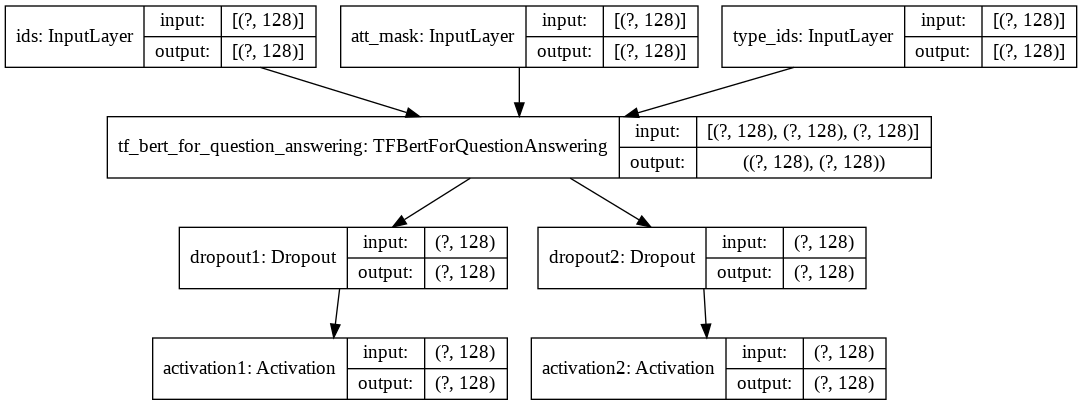

In [ ]:
tf.keras.utils.plot_model(model1, 'Model1.png',show_shapes=True)

In [ ]:
#Creating  directory for model and weights 
import os
import shutil

# shutil.rmtree('/content/Model1')

# os.mkdir('/content/Model1')
os.mkdir('/content/model_save')


In [ ]:
#Setting the parameters for TensorBoard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
!rm -rf ./logs/ 

log_dir='/content/Model1'
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

In [ ]:
#Checkpoint to store the weights
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint('/content/model_save/bert.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')

In [ ]:
#Compiling the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
#Fitting the model and running it for 3 epochs
callback=[tensorboard_callback,checkpoint]
model1.fit({'ids':X_tr1,'att_mask':X_tr2,'type_ids':X_tr3},[Y_tr1,Y_tr2],
           validation_data=({'ids':X_val1,'att_mask':X_val2,'type_ids':X_val3},[Y_val1,Y_val2]),
           batch_size=32,epochs=4,callbacks=callback)

Epoch 1/4
  1/550 [..............................] - ETA: 0s - loss: 9.7204 - activation1_loss: 4.8893 - activation2_loss: 4.8311WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
550/550 [==============================] - ETA: 0s - loss: 4.2212 - activation1_loss: 1.9373 - activation2_loss: 2.2840
Epoch 00001: val_loss improved from inf to 2.61079, saving model to /content/model_save/bert.h5
550/550 [==============================] - 554s 1s/step - loss: 4.2212 - activation1_loss: 1.9373 - activation2_loss: 2.2840 - val_loss: 2.6108 - val_activation1_loss: 1.1455 - val_activation2_loss: 1.4653
Epoch 2/4
550/550 [==============================] - ETA: 0s - loss: 3.7082 - activation1_loss: 1.7057 - activation2_loss: 2.0025
Epoch 00002: val_loss improved from 2.610

In [ ]:
#Saving the model weights
model1.load_weights('/content/model_save/bert.h5')

In [ ]:
%tensorboard --logdir '/content/Model1'

* Optimizer: Adam
* Learning rate: 2e-5
* The training and validation loss reduces for three epochs, after which the validation loss starts to increase. Therefore, the model is trained for three epochs.
* To overcome overfitting,
  * A dropout of 0.2 was applied to BERT model
  * A smaller learning rate was used

In [ ]:
#Model prediction on hold out test dataset
start,end=model1.predict({'ids':X_te1,'att_mask':X_te2,'type_ids':X_te3})

In [ ]:
def jaccard(str1, str2): 
  '''Returns the jaccard score for the given two strings '''
  a = set(str1.lower().split()) 
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#Finds the selected text for the given tweet
def find_selected_text(data,offset,tokenizer,start,end):
  '''Finds the selected text for the given tweet'''
  selected_text_list=[]
  for i in range(data.shape[0]):

    #Finding the start and end index
    start_idx=np.argmax(start[i])
    end_idx=np.argmax(end[i])
    

    #If start is greater than end index, end_index=start_index
    if (start_idx>end_idx):
      end_idx=start_idx

    #Finding the selected text from original tweet
    tweet=data.loc[i,'text']    
    predicted_text=tweet[offset[i][start_idx][0]:offset[i][end_idx][1]]    

    selected_text_list.append(predicted_text)

  return selected_text_list
    


In [ ]:
# Obtaining the predicted selected  text and adding to X_test dataframe
selected_text=find_selected_text(X_test,offsetTe,tokenizer,start,end)
X_test['predicted_text']=selected_text

for i,(_,row) in enumerate(X_test.iterrows()):
  X_test.loc[i,'jaccard']=jaccard(row.selected_text,row.predicted_text)

X_test.head(10)

,textID,text,selected_text,sentiment,predicted_text,jaccard
0,197aa929a2,misses driving already,misses driving already,negative,misses driving already,1.00
1,7648a76c96,name the rest? let`s see. mystery jets are pr...,cool.,positive,name the rest? let`s see. mystery jets are pre...,0.10
2,14fc34a4fb,anyways have a severe headache ryt now! i jst...,anyways have a severe headache ryt now! i jst ...,neutral,anyways have a severe headache ryt now! i jst ...,1.00
3,50662e359b,25-man ulduar is hard...,25-man ulduar is hard...,neutral,25-man ulduar is hard...,1.00
4,b66219e011,cried like a fukn baby today durin da senior s...,miss,negative,cried,0.00
5,6649f3558c,not a prob hun,not a prob,positive,not a prob hun,0.75
6,a54d3c2825,"i know it was worth a shot, though!",as wort,positive,"i know it was worth a shot, though!",0.00
7,db83ff224e,you`re still welcome - the door`s wide enough...,you`re still welcome - the door`s wide enough ...,neutral,you`re still welcome - the door`s wide enough ...,1.00
8,fdbaccd945,"_nickj07 um....nicks voice,smile,eyes,laugh,an...",great,positive,great,1.00
9,1c82fa1e65,reminds me of the weather a month ago it was ...,reminds me of the weather a month ago it was h...,neutral,reminds me of the weather a month ago it was h...,1.00


### Error Analysis

In [ ]:
#Average Jaccard score for each sentiment

pos_average=np.mean(X_test['jaccard'][X_test['sentiment']=='positive'])
print('The average jaccard score for postive sentiment is  ',pos_average)

neg_average=np.mean(X_test['jaccard'][X_test['sentiment']=='negative'])
print('The average jaccard score for negative sentiment is  ',neg_average)

neu_average=np.mean(X_test['jaccard'][X_test['sentiment']=='neutral'])
print('The average jaccard score for neutral sentiment is  ',neu_average)

The average jaccard score for postive sentiment is   0.41717859530336165
The average jaccard score for negative sentiment is   0.3928001901958124
The average jaccard score for neutral sentiment is   0.976394455933297


In [ ]:
#Adding len of the selected text column

X_test['len_selected_text']=X_test['selected_text'].apply(lambda x: len(x.split()))
X_test['len_text']=X_test['text'].apply(lambda x: len(x.split()))
X_test['diff_len']=abs(X_test['len_selected_text']-X_test['len_text'])
X_test.head()

,textID,text,selected_text,sentiment,predicted_text,jaccard,len_selected_text,len_text,diff_len
0,197aa929a2,misses driving already,misses driving already,negative,misses driving already,1.0,3,3,0
1,7648a76c96,name the rest? let`s see. mystery jets are pr...,cool.,positive,name the rest? let`s see. mystery jets are pre...,0.1,1,20,19
2,14fc34a4fb,anyways have a severe headache ryt now! i jst...,anyways have a severe headache ryt now! i jst ...,neutral,anyways have a severe headache ryt now! i jst ...,1.0,24,24,0
3,50662e359b,25-man ulduar is hard...,25-man ulduar is hard...,neutral,25-man ulduar is hard...,1.0,4,4,0
4,b66219e011,cried like a fukn baby today durin da senior s...,miss,negative,cried,0.0,1,15,14


In [ ]:
#Total number of tweets with correct prediction and incorrect prediction
pos_jac_1=X_test[X_test['jaccard']==1]
pos_jac_0=X_test[X_test['jaccard']!=1]

In [ ]:
print('The total number of  tweets is',X_test.shape[0])
print('The total number of  tweets with jaccard=1 is',pos_jac_1.shape[0])
print('The total number of  tweets with jaccard not 1 is',pos_jac_0.shape[0])

The total number of  tweets is 4397
The total number of  tweets with jaccard=1 is 2141
The total number of  tweets with jaccard not 1 is 2256


In [ ]:
#Performance of model when both tweet and selected text is same

total_zero_diff=X_test[X_test['diff_len']==0].shape[0]
zero_diff_jaccard_1=pos_jac_1[pos_jac_1['diff_len']==0].shape[0]
result=zero_diff_jaccard_1*100/total_zero_diff
print('The percentage of  tweets with jaccard=1 when both tweet and selected text were same is',result)

The percentage of  tweets with jaccard=1 when both tweet and selected text were same is 85.80677290836654


In [ ]:
#Performance of model when difference between  tweet and selected text is less than 10

diff_less_10=X_test[X_test['diff_len']<=10].shape[0]
diff_less_10_jaccard_1=pos_jac_1[pos_jac_1['diff_len']<=10].shape[0]
result=diff_less_10_jaccard_1*100/diff_less_10
print('The percentage of tweets with jaccard=1 when length difference is less than 10 is',result)

The percentage of tweets with jaccard=1 when length difference is less than 10 is 60.28737389177621


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 10 but less than 20

diff_less_20=X_test[(X_test['diff_len']>10) & (X_test['diff_len']<=20)].shape[0]
diff_less_20_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>10) & (pos_jac_1['diff_len']<=20)].shape[0]
result=diff_less_20_jaccard_1*100/diff_less_20
print('The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is',result)

The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is 15.488215488215488


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 20

diff_less_30=X_test[(X_test['diff_len']>20)].shape[0]
diff_less_30_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>20)].shape[0]
result=diff_less_30_jaccard_1*100/diff_less_30
print('The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is',result)

The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is 13.191489361702128


In [ ]:
print(np.mean(X_test['jaccard']))

0.6365313134524992


Conclusion
* The Bert model performs well when the text and selected text are of same length.
* It does resonablly well when the difference between tweet selected text is of only few words but does not perform well when the difference increases.

### Prepare For Kaggle submission

In [ ]:
#Prepare data as required for BERT QA model

def computeData(text,sentiment,tokenizer):

  '''Prepare data as required for BERT QA model'''
  token_encode=tokenizer.encode(text)
  token_ids=token_encode.ids[1:-1]
  token_offsets=token_encode.offsets[1:-1]
  
  #Creating the input data to the BERT model
  input_ids=[101]+[sentiment_dict[sentiment]]+[102]+token_ids+[102]
  atten_mask=[1]*4+[1]*len(token_ids)
  input_type_ids=[0,0,0]+[1]*(len(token_ids)+1) 

  offsets=[(0,0)]*3+token_offsets+[(0,0)]



  pad_length=MAX_LEN-len(input_ids)

  if(pad_length>0):
      input_ids=input_ids+([0]*pad_length)
      atten_mask=atten_mask+([0]*pad_length)
      input_type_ids=input_type_ids+([0]*pad_length)
      offsets=offsets+([(0,0)]*pad_length)
      
  return (input_ids,atten_mask,input_type_ids,offsets)

In [ ]:
#Create Test dataset as per BERT QA model

def createTestData(data,tokenizer):
  '''Create Test dataset as per BERT QA model'''
  input_ids=[]
  input_att_mask=[]
  input_type_ids=[]
  offsets=[]
  for _,i in tqdm(data.iterrows()): 
      ids,att_mask,type_ids,offset=computeData(i['text'],i['sentiment'],tokenizer)      
      input_ids.append(ids)
      input_att_mask.append(att_mask)
      input_type_ids.append(type_ids)
      offsets.append(offset)
  return (np.asarray(input_ids,dtype=np.int32),np.asarray(input_att_mask,dtype=np.int32),
        np.asarray(input_type_ids,dtype=np.int32),np.asarray(offsets,dtype=np.int32))

In [ ]:
#Applying the above methods on test dataset
test['text']=test['text'].apply(lambda x: str.lower(x))
test1,test2,test3,offsets=createTestData(test,tokenizer)

3534it [00:01, 3348.61it/s]


In [ ]:
#Prediction on test dataset
start,end=model1.predict({'ids':test1,'att_mask':test2,'type_ids':test3})

In [ ]:
#Find the selected text and create the submission file

selected_text=find_selected_text(test,offsets,tokenizer,start,end)
submission=pd.DataFrame(columns=['textID','selected_text'])
submission['textID']=test['textID']
submission['selected_text']=selected_text

submission.to_csv('/content/submission.csv',index=False)

Kaggle Score
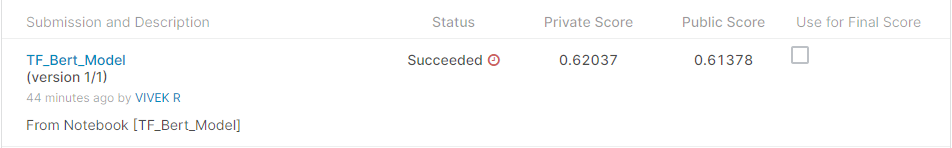